In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from wrangle import wrangle_zillow, acquire_sec
from evaluate import baseline_mean_errors, better_than_baseline, regression_errors, plot_residuals, mets, eval_score, more_table
from explore import plot_categorical_and_continuous_vars, plot_variable_pairs
from sklearn.feature_selection import SelectKBest, f_regression, RFE

## Acquisition and Preparation

In [2]:
# grabbing data, cleaning, and splitting
df = wrangle_zillow()
df_2 = acquire_sec()
df_2 = df_2.drop(columns={'latitude', 'longitude', 'lotsizesquarefeet', 'transactiondate'})
df = df.merge(df_2, how='inner').drop(columns = 'parcelid')
train_and_validate, test = train_test_split(df, random_state=117)
train, validate = train_test_split(train_and_validate)

x_train = train.drop(columns={'beds', 'value', 'year_built', 'county'})
y_train = train['value']
x_validate = validate.drop(columns={'beds', 'value', 'year_built', 'county'})
y_validate = validate['value']
x_test = test.drop(columns={'beds', 'value', 'year_built', 'county'})
y_test = test['value']

In [3]:
# a quick look to see what we're seeing
train.sample(5)

,beds,baths,square_feet,value,year_built,county
43802,3,1.0,999,816420,1952,6111.0
11950,4,2.0,1781,435541,1939,6037.0
37642,2,1.0,744,143929,1948,6037.0
22807,4,3.0,2347,772000,1974,6037.0
22728,4,3.0,2672,233022,1958,6059.0


## Exploration

In [4]:
# visualizing correlation of features
value_corr = train.corr()
value_corr

,beds,baths,square_feet,value,year_built,county
beds,1.000000,0.645937,0.637019,0.288383,0.377417,0.131029
baths,0.645937,1.000000,0.852926,0.518808,0.514881,0.099233
square_feet,0.637019,0.852926,1.000000,0.602404,0.444721,0.101603
value,0.288383,0.518808,0.602404,1.000000,0.159274,0.016478
year_built,0.377417,0.514881,0.444721,0.159274,1.000000,0.295055
county,0.131029,0.099233,0.101603,0.016478,0.295055,1.000000


In [5]:
x = df.square_feet
y = df.value
α = 0.05
# we're using pearson since we're determining the linear relationship between square feet and value
corr, p = stats.pearsonr(x, y)
if p < α:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


## Select a dataset with a continuous target variable.

In [6]:
df.head()

,beds,baths,square_feet,value,year_built,county
0,4,5.0,3760,872850,1982,6111.0
1,3,2.0,1444,436157,1951,6111.0
2,3,1.5,1698,286606,1979,6111.0
3,2,1.0,1170,592930,1948,6111.0
4,3,2.0,1257,462900,1930,6111.0


## Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [7]:
# the data is all in numeric form
df.dtypes

beds             int64
baths          float64
square_feet      int64
value            int64
year_built       int64
county         float64
dtype: object

In [8]:
# making sure there's no nulls
df.isnull().sum()

beds           0
baths          0
square_feet    0
value          0
year_built     0
county         0
dtype: int64

In [9]:
# splitting the data
train_and_validate, test = train_test_split(df, random_state=117)
train, validate = train_test_split(train_and_validate)

x_train = train.drop(columns={'value'})
y_train = train['value']
x_validate = validate.drop(columns={'value'})
y_validate = validate['value']
x_test = test.drop(columns={'value'})
y_test = test['value']

### Determining the best scaler

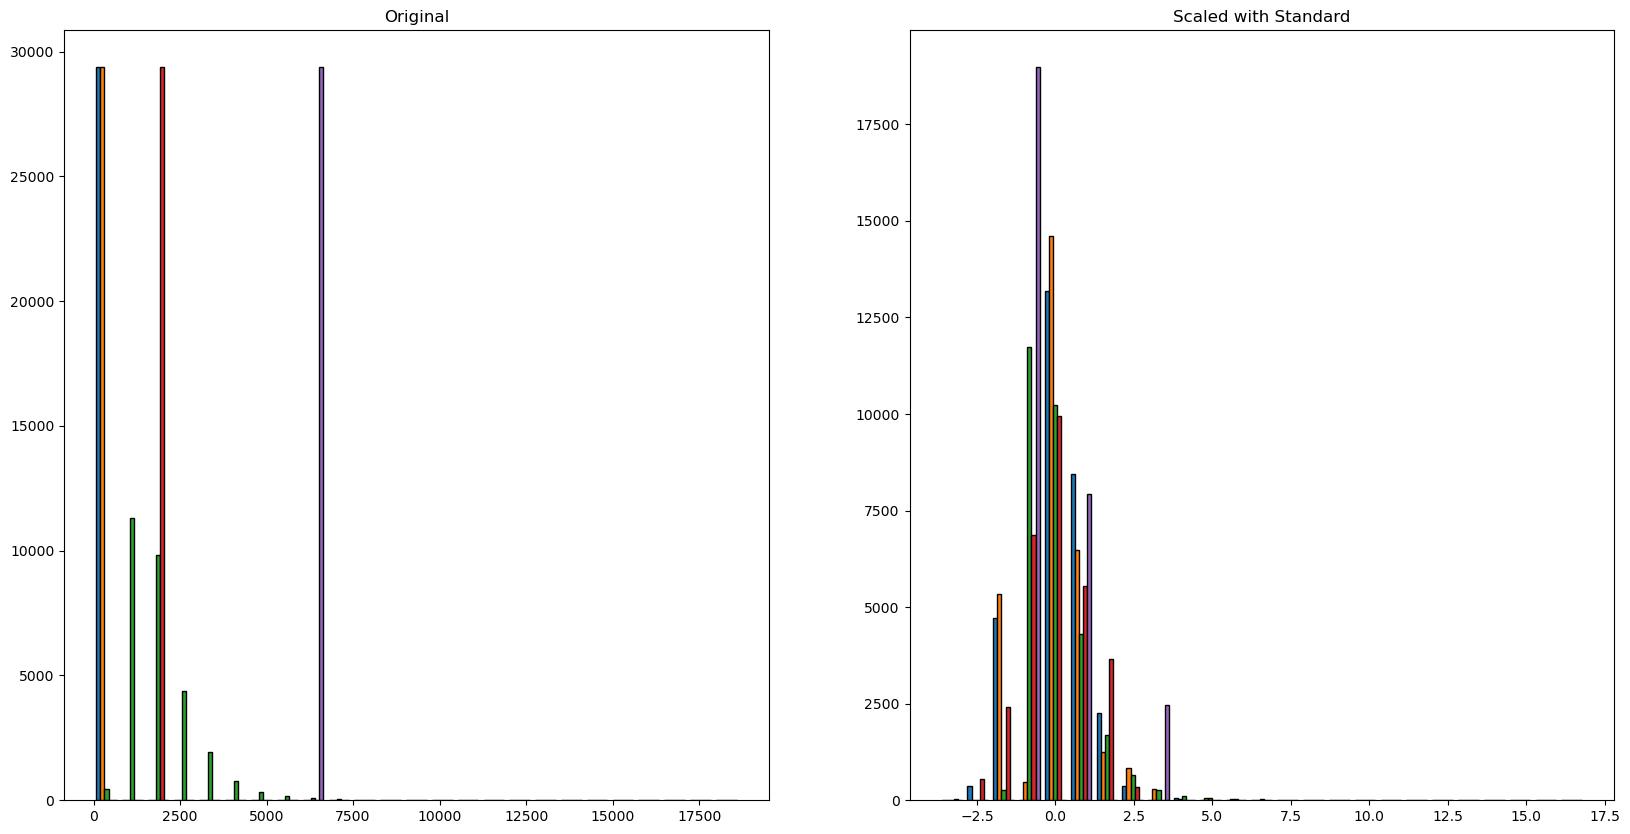

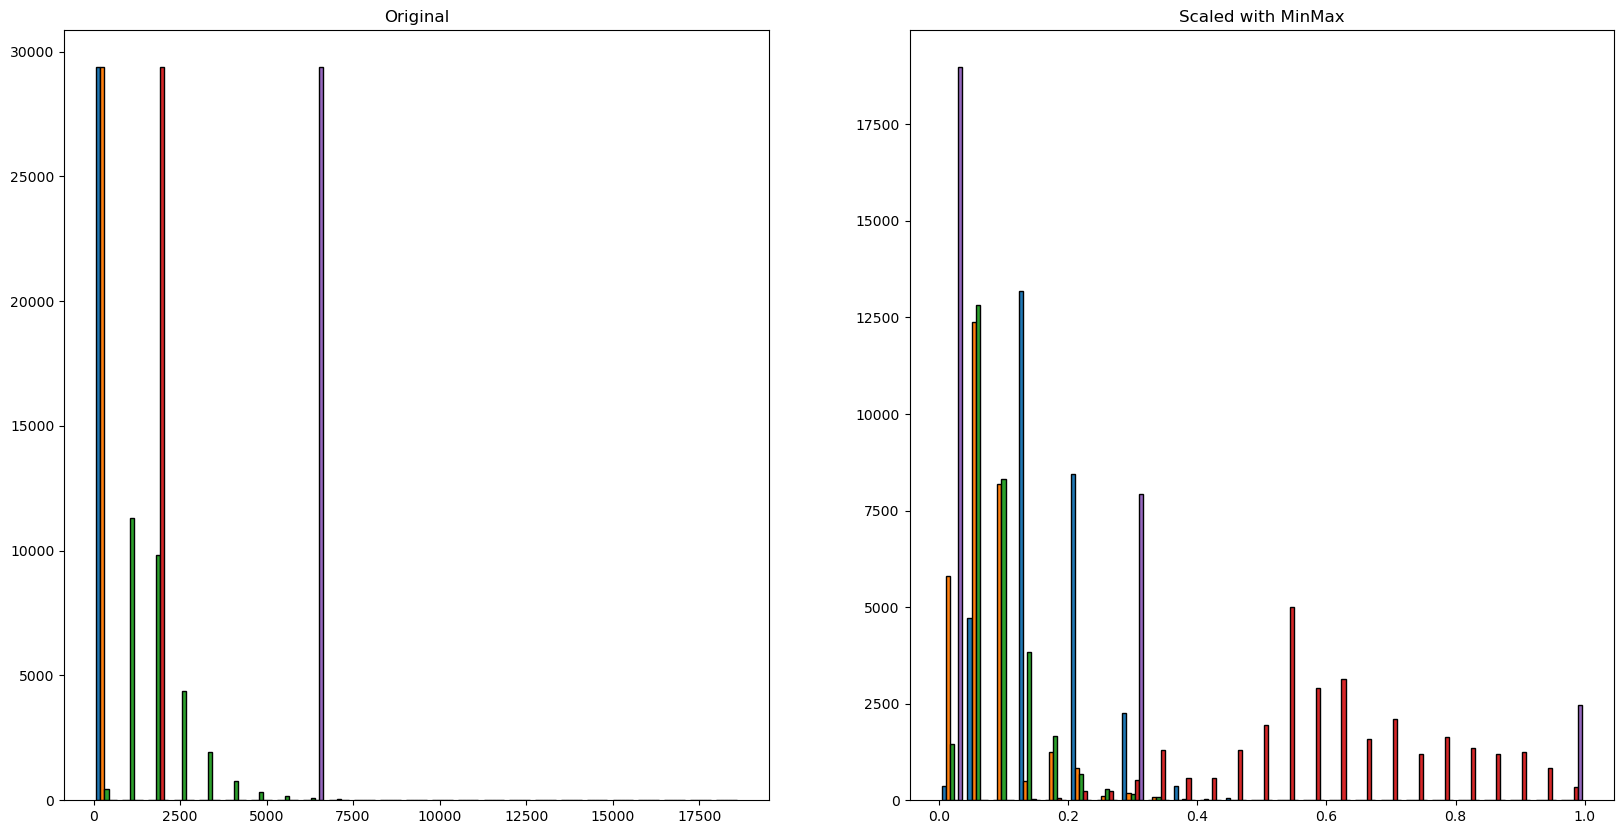

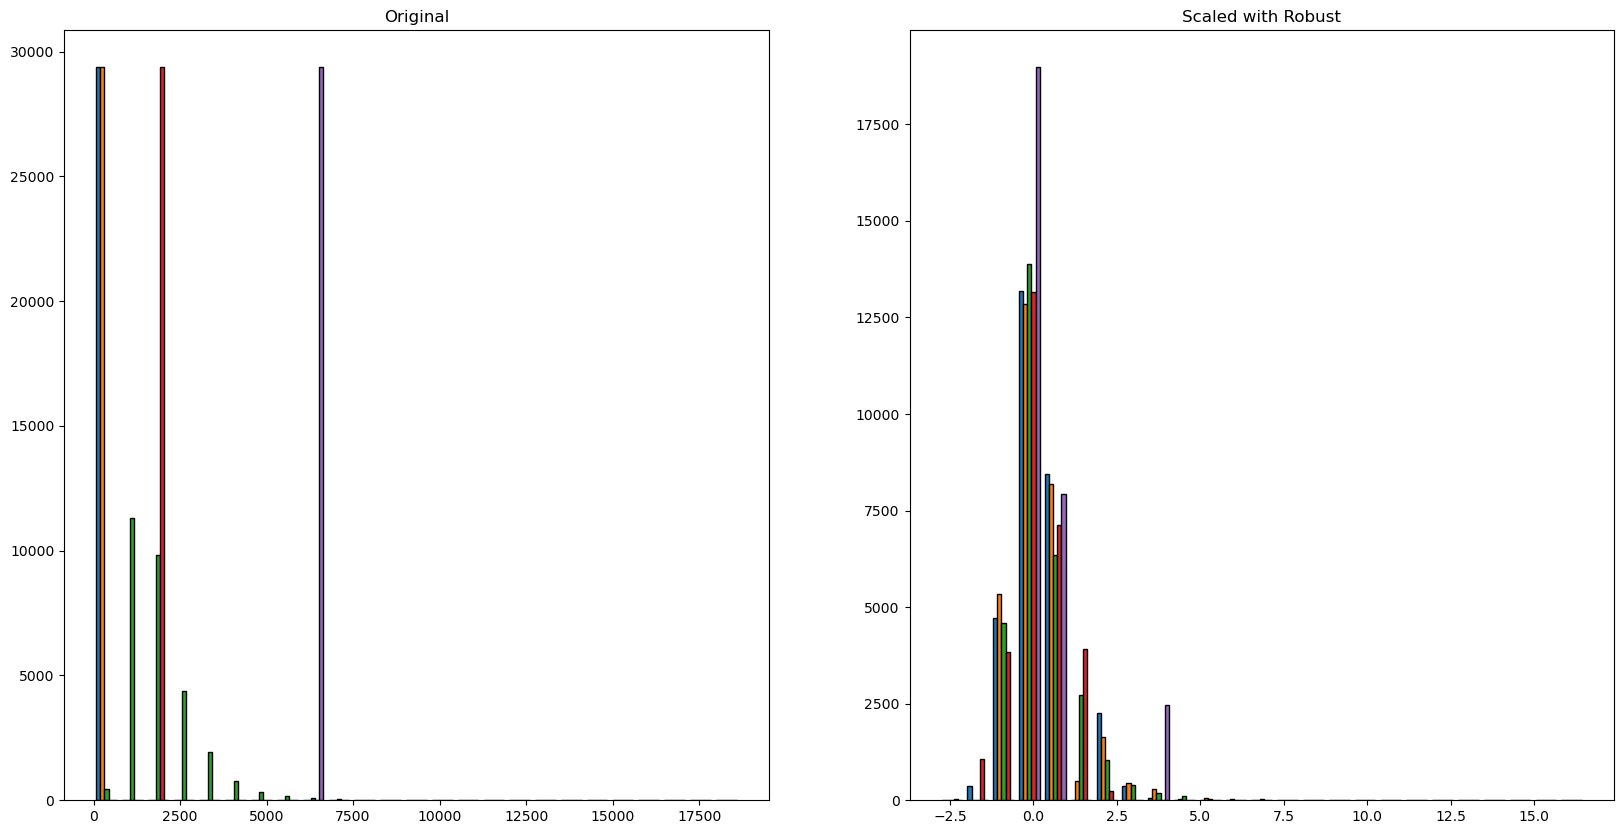

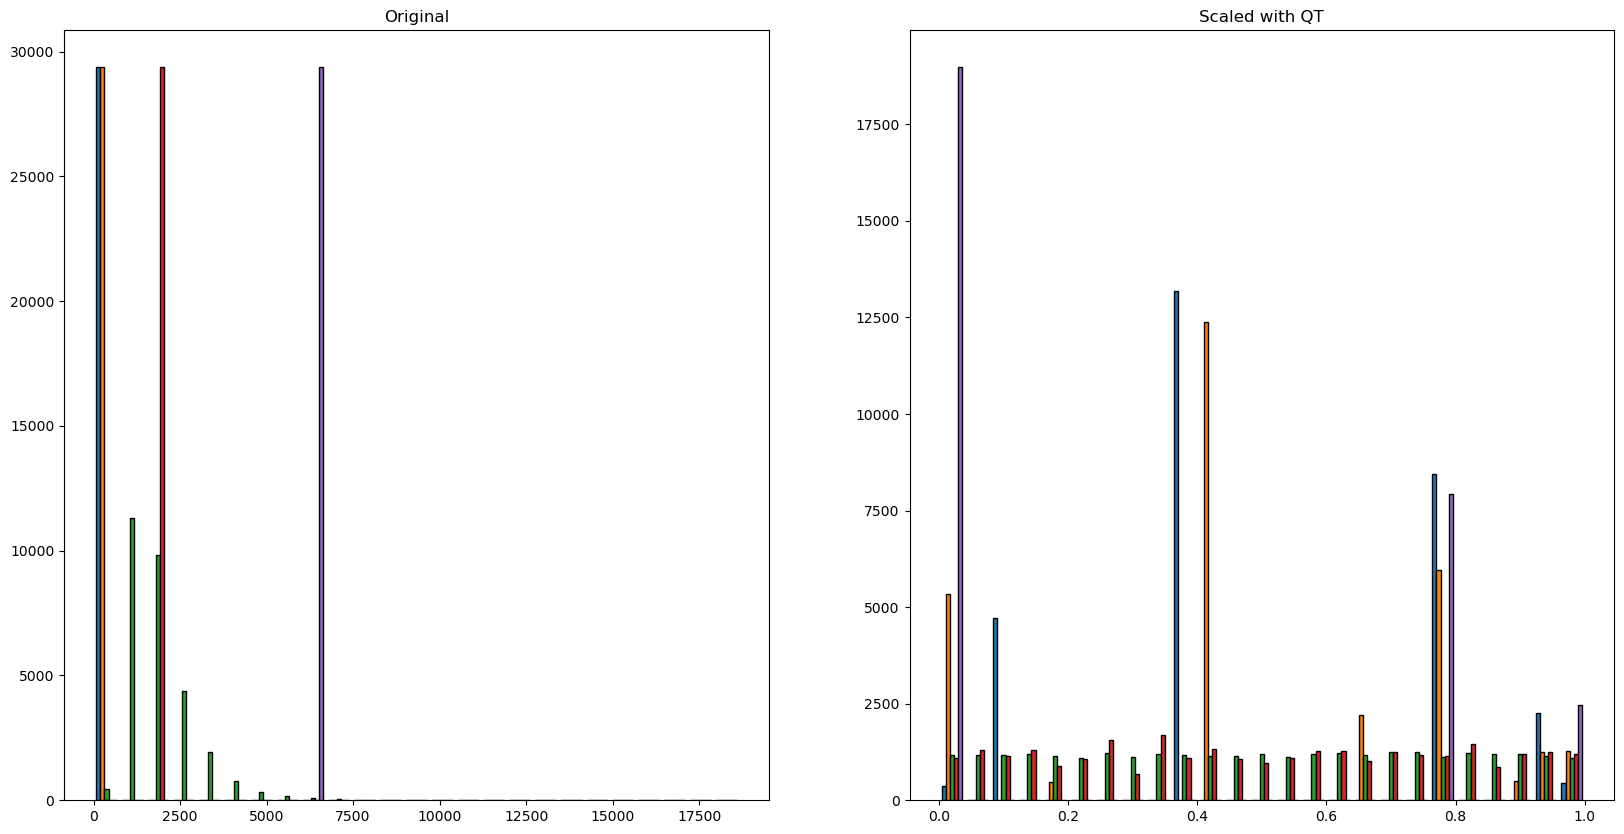

In [10]:
# Determining best scaler to use with data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with Standard')
plt.show()


scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with MinMax')
plt.show()


scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with Robust')
plt.show()


scaler = sklearn.preprocessing.QuantileTransformer()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.hist(x_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled with QT')
plt.show()

In [11]:
# Scaling the data to Robust scaler since it performed the best
scaler = sklearn.preprocessing.RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

In [12]:
lr1 = LinearRegression()
rfe = RFE(lr1, n_features_to_select=1)
rfe.fit(x_train_scaled, y_train)
rfe_train_feature = rfe.transform(x_train_scaled)
rfe_validate_feature = rfe.transform(x_validate_scaled)

In [13]:
lr1 = LinearRegression()
rfe = RFE(lr1, n_features_to_select=1)
rfe.fit(x_train_scaled, y_train)
rfe_train_feature = rfe.transform(x_train_scaled)
rfe_validate_feature = rfe.transform(x_validate_scaled)
rfe.get_feature_names_out()

array(['x2'], dtype=object)

sns.histplot(y_train)
plt.xlim([0, 2000000])
plt.show()

## Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

### Establishing baseline and making a dataframe to visually reference easier

In [14]:
def mets(y, y_pred):
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    return rmse, r2

In [15]:
baseline =y_train.mean()
baseline_array = np.repeat(baseline, len(train))
rmse, r2 = mets(y_train, baseline_array)
mets_df = pd.DataFrame(data=[{'Model':'Baseline', 'RMSE':rmse, 'R2':r2}])

train_target_pred_mean = y_train.mean()
validate_target_pred_mean = y_validate.mean()


train_target_pred_median = y_train.median()
validate_target_pred_median = y_validate.median()

In [16]:
mets_df

,Model,RMSE,R2
0,Baseline,752968.712452,0.0


### Now to try out different models and see what's optimal

In [17]:
score_df = pd.DataFrame(data=[{'Model':'Baseline', 'RMSE':rmse, 'R2':r2}])
lr1.fit(rfe_train_feature, y_train)
pred_train_lr1 = lr1.predict(rfe_train_feature)
pred_validate_lr1 = lr1.predict(rfe_validate_feature)
pred_train_lr1


mets(y_train, pred_train_lr1)

(606266.2892792728, 0.3517045409402638)

#### LinearRegression (OLS)

In [18]:
lr1.fit(rfe_train_feature, y_train)
pred_train_lr1 = lr1.predict(rfe_train_feature)
pred_validate_lr1 = lr1.predict(rfe_validate_feature)
pred_train_lr1

array([ 447043.0187159 , 1006227.64845593,  241003.95160332, ...,
        384061.64448934,  178022.57737676, 1117344.78726992])

In [19]:
mets(y_train, pred_train_lr1)

(606266.2892792728, 0.3517045409402638)

In [20]:
val_rmse, val_r2 = mets(y_validate, pred_validate_lr1)
val_rmse, val_r2

(584143.309099509, 0.3857027358851155)

In [21]:
mets_df.loc[1] = ['OLS_1', val_rmse, val_r2]
mets_df

,Model,RMSE,R2
0,Baseline,752968.712452,0.000000
1,OLS_1,584143.309100,0.385703


In [22]:
lr1.intercept_

406554.99242739764

In [23]:
lr1.coef_

array([463362.96752392])

In [24]:
lr2 = LinearRegression()
lr2.fit(x_train_scaled, y_train)
pred_lr2 = lr2.predict(x_train_scaled)
pred_val_lr2 = lr2.predict(x_validate_scaled)
pred_lr2

array([451217.58775492, 864948.99136175, 316231.95455413, ...,
       231236.40692526, 366780.23702666, 936524.91276173])

In [25]:
mets(y_train, pred_lr2)

(589485.1617097235, 0.3870967926594501)

In [26]:
rmse, r2 = mets(y_validate, pred_val_lr2)
rmse, r2

(571656.037007301, 0.4116857654411)

In [27]:
mets_df.loc[2] = ['OLS', rmse, r2]
mets_df

,Model,RMSE,R2
0,Baseline,752968.712452,0.000000
1,OLS_1,584143.309100,0.385703
2,OLS,571656.037007,0.411686


#### LassoLars

In [28]:
lars = LassoLars(alpha=3)
lars.fit(x_train_scaled, y_train)
pred_lars = lars.predict(x_train_scaled)
pred_lars_val = lars.predict(x_validate_scaled)

In [29]:
mets(y_train, pred_lars)

(589485.1617913342, 0.3870967924897447)

In [30]:
def eval_score(y_validate, pred_val):
    rmse, r2 = mets(y_validate, pred_val)
    return rmse, r2

def more_table(row, row_name, res1, res2):
    rmse, r2 = res1, res2
    mets_df.loc[row] = [row_name, rmse, r2]
    return mets_df

In [31]:
rmse, r2= eval_score(y_validate, pred_lars_val)
more_table(3, 'Lars', rmse, r2)

,Model,RMSE,R2
0,Baseline,752968.712452,0.000000
1,OLS_1,584143.309100,0.385703
2,OLS,571656.037007,0.411686
3,Lars,571655.795396,0.411686


#### Polynomial Regression

In [32]:
pf = PolynomialFeatures(degree=2)
x_train_scaled_degree2 = pf.fit_transform(x_train_scaled)
x_validate_degree2 = pf.transform(x_validate_scaled)

In [33]:
pr = LinearRegression()
pr.fit(x_train_scaled_degree2, y_train)
pred_pr = pr.predict(x_train_scaled_degree2)
pred_val_pr = pr.predict(x_validate_degree2)

In [34]:
mets(y_train, pred_pr)

(523809.71810842043, 0.5160580816300007)

In [35]:
rmse, r2 = eval_score(y_validate, pred_val_pr)
more_table(4, 'Poly Reg deg 2', rmse, r2)

,Model,RMSE,R2
0,Baseline,752968.712452,0.000000
1,OLS_1,584143.309100,0.385703
2,OLS,571656.037007,0.411686
3,Lars,571655.795396,0.411686
4,Poly Reg deg 2,572830.836871,0.409265


In [36]:
pf = PolynomialFeatures(degree=3)
x_train_scaled_degree3 = pf.fit_transform(x_train_scaled)
x_validate_degree3 = pf.transform(x_validate_scaled)
pr = LinearRegression()
pr.fit(x_train_scaled_degree3, y_train)
pred_pr = pr.predict(x_train_scaled_degree3)
pred_val_pr = pr.predict(x_validate_degree3)

In [37]:
mets(y_train, pred_pr)

(507255.508888588, 0.5461632263159896)

In [38]:
rmse, r2 = eval_score(y_validate, pred_val_pr)
more_table(5, 'Poly Reg deg3', rmse, r2)

,Model,RMSE,R2
0,Baseline,752968.712452,0.000000
1,OLS_1,584143.309100,0.385703
2,OLS,571656.037007,0.411686
3,Lars,571655.795396,0.411686
4,Poly Reg deg 2,572830.836871,0.409265
5,Poly Reg deg3,585680.602137,0.382465


#### TweedieRegressor (GLM)

In [39]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train_scaled, y_train)
pred_glm = glm.predict(x_train_scaled)
pred_val_glm = glm.predict(x_validate_scaled)

In [40]:
mets(y_train, pred_glm)

(927146.0858470087, -0.5161510709895869)

In [41]:
rmse, r2 = eval_score(y_validate, pred_val_glm)
more_table(6, 'TweedieRegressor 1', rmse, r2)

,Model,RMSE,R2
0,Baseline,7.529687e+05,0.000000
1,OLS_1,5.841433e+05,0.385703
2,OLS,5.716560e+05,0.411686
3,Lars,5.716558e+05,0.411686
4,Poly Reg deg 2,5.728308e+05,0.409265
5,Poly Reg deg3,5.856806e+05,0.382465
6,TweedieRegressor 1,2.852177e+06,-13.645112


In [42]:
glm2 = TweedieRegressor(power=0, alpha=0)
glm2.fit(x_train_scaled, y_train)
pred_glm2 = glm2.predict(x_train_scaled)
pred_val_glm2 = glm2.predict(x_validate_scaled)

In [43]:
mets(y_train, pred_glm2)

(589485.1617097235, 0.3870967926594502)

In [44]:
rmse, r2 = eval_score(y_validate, pred_val_glm2)
more_table(7, 'TweedieRegressor 2', rmse, r2)

,Model,RMSE,R2
0,Baseline,7.529687e+05,0.000000
1,OLS_1,5.841433e+05,0.385703
2,OLS,5.716560e+05,0.411686
3,Lars,5.716558e+05,0.411686
4,Poly Reg deg 2,5.728308e+05,0.409265
5,Poly Reg deg3,5.856806e+05,0.382465
6,TweedieRegressor 1,2.852177e+06,-13.645112
7,TweedieRegressor 2,5.716560e+05,0.411686


In [45]:
glm3 = TweedieRegressor(power=2, alpha=0)
glm3.fit(x_train_scaled, y_train)
pred_glm3 = glm3.predict(x_train_scaled)
pred_val_glm3 = glm3.predict(x_validate_scaled)

In [46]:
mets(y_train, pred_glm3)

(30486772.462483443, -1638.340006442906)

In [49]:
rmse, r2 = eval_score(y_validate, pred_val_glm3)
more_table(8, 'TweedieRegressor 3', rmse, r2)

,Model,RMSE,R2
0,Baseline,7.529687e+05,0.000000
1,OLS_1,5.841433e+05,0.385703
2,OLS,5.716560e+05,0.411686
3,Lars,5.716558e+05,0.411686
4,Poly Reg deg 2,5.728308e+05,0.409265
5,Poly Reg deg3,5.856806e+05,0.382465
6,TweedieRegressor 1,2.852177e+06,-13.645112
7,TweedieRegressor 2,5.716560e+05,0.411686
8,TweedieRegressor 3,1.084024e+08,-21154.222878


Baseline is off by about $752,968

Best model Tweedie Regressor 2 is off by about $571,656

Percent of variance (R$^2$) by GLM 2 is 41.16%

In [52]:
train['beds'].value_counts()

beds
3     13176
4      8442
2      4708
5      2252
6       361
1       358
7        67
8        13
9         3
12        2
14        1
11        1
10        1
Name: count, dtype: int64